# Data Source: https://www.kaggle.com/ryanxjhan/cbc-news-coronavirus-articles-march-26/version/1
# Question:Has the news media been overreacting or under-reacting during the development of COVID-19?

# Import required Libraries

In [1]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', -1)
from time import time
import re
import string
import os
import collections
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)

import nltk 
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
from nltk.stem import PorterStemmer
import string, re
import random

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.externals import joblib
import pickle

import warnings
warnings.filterwarnings('ignore')
np.random.seed(37)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rajla\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rajla\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rajla\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\rajla\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Read Data

In [2]:
df = pd.read_csv(r"C:\Users\rajla\Desktop\news_csvfile\news.csv")
#df.head(3)

In [3]:
len(df)

3566

In [4]:
df.dtypes

Unnamed: 0      int64 
authors         object
title           object
publish_date    object
description     object
text            object
url             object
dtype: object

# Check null values before analysis

In [5]:
df.isna().sum()

Unnamed: 0      0
authors         0
title           0
publish_date    0
description     0
text            0
url             0
dtype: int64

In [6]:
# Any blank value in text of 'df.title'

blanks = []

for ix, i, au, ti, pd, de, tx, ur in df.itertuples():
    if ti.isspace():
        blanks.append(i)
blanks

[]

In [7]:
# Any blank value in text of 'df.text'

blanks = []

for ix, i, au, ti, pd, de, tx, ur in df.itertuples():
    if tx.isspace():
        blanks.append(i)
blanks

[]

# Finding the top ten words with default stopwords

In [8]:
def plot_10_most_common_words(count_data, count_vectorizer):  
    words = count_vectorizer.get_feature_names()  
    total_counts = np.zeros(len(words))  
    for t in count_data:  
        total_counts+=t.toarray()[0] 
        count_dict = (zip(words, total_counts))  
        count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]  
        words = [w[0] for w in count_dict]  
        counts = [w[1] for w in count_dict]  
        x_pos = np.arange(len(words))   
     
    plt.figure(2, figsize=(15, 15/1.6180))  
    plt.subplot(title='10 most common words')  
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})  
    sns.barplot(x_pos, counts, palette='husl')  
    plt.xticks(x_pos, words, rotation=90)   
    plt.xlabel('words')  
    plt.ylabel('counts')  
    plt.show()

In [9]:
count_vectorizer = CountVectorizer(stop_words='english')  
count_data = count_vectorizer.fit_transform(df['text'])

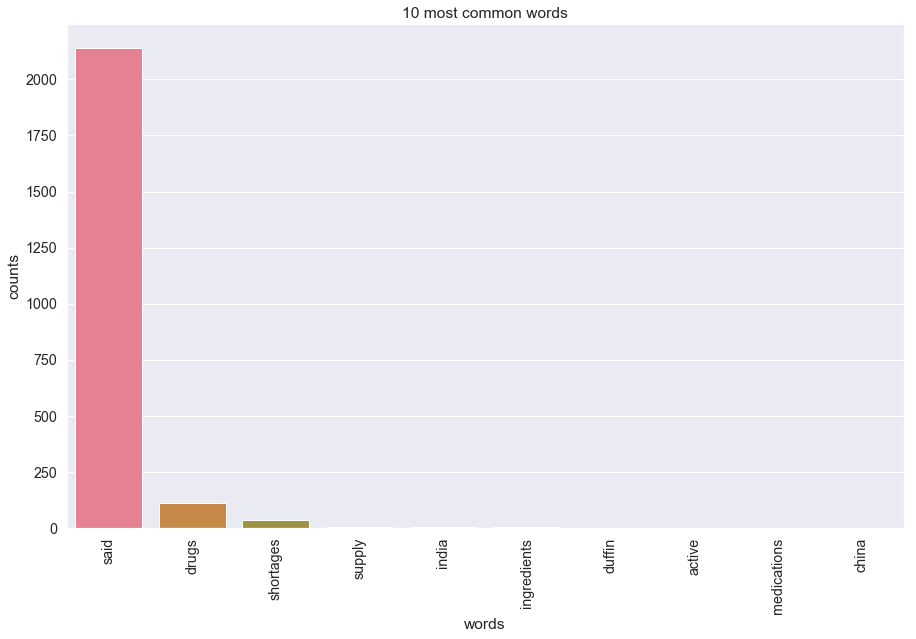

In [10]:
plot_10_most_common_words(count_data, count_vectorizer)  

# There are words in the above graph which seems not important so we need to remove such words, for which we will do text pre-processing.

# Text Preparation 



# 1. Covert text to lowercase

In [11]:
text = str(df['text'])
text = text.lower()

In [12]:
#df['text'].head()

# 2. Remove Numbers

In [13]:
import re
df['text'] = re.sub(r'\dt','',text)

In [14]:
#df['text'].head()

# 3. Remove punctuation(text)


In [15]:

sentences = sent_tokenize(str(df['text']))
def remove_punctuation(sentence):
    sentence = re.sub(r'[^\w\s]','',sentence)
    return sentence
cleaned_sent = [remove_punctuation(sentence) for sentence in sentences]
print(cleaned_sent[:3])

['0       0       canadian pharmacies are limiting how much medication can be dispensed to try to prevent shortages recognizing that most active ingredients for drugs come from india and china and medical supply chains have been disrupted by the spread of covid19', 'provincial regulatory colleges are complying with the canadian pharmacists association call to limit the amount of medications given to patients to 30day\xa0supplies', 'the goal is to stop people from refilling prescriptions early and to ensure lifesaving drugs dont run short when supply chains are\xa0vulnerable']


In [16]:
Article_words = [word_tokenize(sentence) for sentence in cleaned_sent]
print(Article_words[:3])

[['0', '0', 'canadian', 'pharmacies', 'are', 'limiting', 'how', 'much', 'medication', 'can', 'be', 'dispensed', 'to', 'try', 'to', 'prevent', 'shortages', 'recognizing', 'that', 'most', 'active', 'ingredients', 'for', 'drugs', 'come', 'from', 'india', 'and', 'china', 'and', 'medical', 'supply', 'chains', 'have', 'been', 'disrupted', 'by', 'the', 'spread', 'of', 'covid19'], ['provincial', 'regulatory', 'colleges', 'are', 'complying', 'with', 'the', 'canadian', 'pharmacists', 'association', 'call', 'to', 'limit', 'the', 'amount', 'of', 'medications', 'given', 'to', 'patients', 'to', '30day', 'supplies'], ['the', 'goal', 'is', 'to', 'stop', 'people', 'from', 'refilling', 'prescriptions', 'early', 'and', 'to', 'ensure', 'lifesaving', 'drugs', 'dont', 'run', 'short', 'when', 'supply', 'chains', 'are', 'vulnerable']]


# Removing Stopwords

In [17]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [18]:
stop_words = stopwords.words('english')
print('Number of stopwords :', len(stop_words))

Number of stopwords : 179


In [19]:
# Adding words in stopwords list
stop_words.append('said')
stop_words.append('come')
stop_words.append('may')
stop_words.append('says')
stop_words.append('also')
stop_words.append('The')
stop_words.append('people')
stop_words.append('It')
stop_words.append('would')
stop_words.append('like')
stop_words.append('But')
stop_words.append('one')
stop_words.append('He')
stop_words.append('could')
len(stop_words)

193

In [20]:
def remove_stopword(sentence):
    return [w for w in sentence if not w in stop_words]


filtered = [remove_stopword(s) for s in Article_words]
word_count = len ([ w for words in Article_words for w in words])
word_count2 = len([w for words in filtered for w in words])
print(f'Number of words before removing stop words :{word_count}')
print(f'Number of words after removing stop words : {word_count2}')
print(filtered[:3])

Number of words before removing stop words :3502026
Number of words after removing stop words : 1970646
[['0', '0', 'canadian', 'pharmacies', 'limiting', 'much', 'medication', 'dispensed', 'try', 'prevent', 'shortages', 'recognizing', 'active', 'ingredients', 'drugs', 'india', 'china', 'medical', 'supply', 'chains', 'disrupted', 'spread', 'covid19'], ['provincial', 'regulatory', 'colleges', 'complying', 'canadian', 'pharmacists', 'association', 'call', 'limit', 'amount', 'medications', 'given', 'patients', '30day', 'supplies'], ['goal', 'stop', 'refilling', 'prescriptions', 'early', 'ensure', 'lifesaving', 'drugs', 'dont', 'run', 'short', 'supply', 'chains', 'vulnerable']]


# Parts of speech tagging - 

In [177]:

nltk.download('averaged_perceptron_tagger')

POS = [nltk.pos_tag(tokenized_sent) for tokenized_sent in filtered]
print(POS[:3])

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rajla\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[[('0', 'CD'), ('Canadian', 'JJ'), ('pharmacies', 'NNS'), ('limiting', 'VBG'), ('much', 'JJ'), ('medication', 'NN'), ('dispensed', 'VBD'), ('try', 'VB'), ('prevent', 'NN'), ('shortages', 'NNS'), ('recognizing', 'VBG'), ('active', 'JJ'), ('ingredients', 'NNS'), ('drugs', 'NNS'), ('India', 'NNP'), ('China', 'NNP'), ('medical', 'JJ'), ('supply', 'NN'), ('chains', 'NNS'), ('disrupted', 'VBN'), ('spread', 'NN'), ('COVID19', 'NNP')], [('Provincial', 'JJ'), ('regulatory', 'JJ'), ('colleges', 'NNS'), ('complying', 'VBG'), ('Canadian', 'JJ'), ('Pharmacists', 'NNP'), ('Association', 'NNP'), ('call', 'VB'), ('limit', 'NN'), ('amount', 'NN'), ('medications', 'NNS'), ('given', 'VBN'), ('patients', 'NNS'), ('30day', 'CD'), ('supplies', 'NNS')], [('goal', 'NN'), ('stop', 'NN'), ('refilling', 'VBG'), ('prescriptions', 'NNS'), ('early', 'JJ'), ('ensure', 'VB'), ('lifesaving', 'VBG'), ('drugs', 'NNS'), ('dont', 'JJ'), ('run', 'VBP'), ('short', 'JJ'), ('supply', 'NN'), ('chains', 'NNS'), ('vulnerable', '

# Concordance 

In [178]:
# just to check how it works

from nltk.text import Text
words = Text(word_tokenize(str(df['text'])))
words.concordance('coronavirus')


Displaying 25 of 160 matches:
, none of which she attributes to coronavirus . China and India produce 80 per 
Duffin said . `` I think that the coronavirus outbreak is a big wake-up call fo
ople may have been exposed to the coronavirus in recent weeks . In a news relea
alth care systems engulfed by the coronavirus pandemic . The unanimous vote cam
 rocket ship '' when it 's over . Coronavirus impact spreads across U.S. , with
ts assured them that a additional coronavirus legislation will follow this spri
he sprawling measure is the third coronavirus response bill produced by Congres
stairway , ahead of a vote on the coronavirus relief bill , on Capitol Hill in 
 prevent infection from the novel coronavirus . The response has been especiall
0 who test positive for the novel coronavirus to study whether colchicine , an 
 four decades has been working on coronavirus vaccines primarily for animals , 
n safety tests of an experimental coronavirus vaccine . March 16 : Scientists a
ion tea . 

# Word Clouds

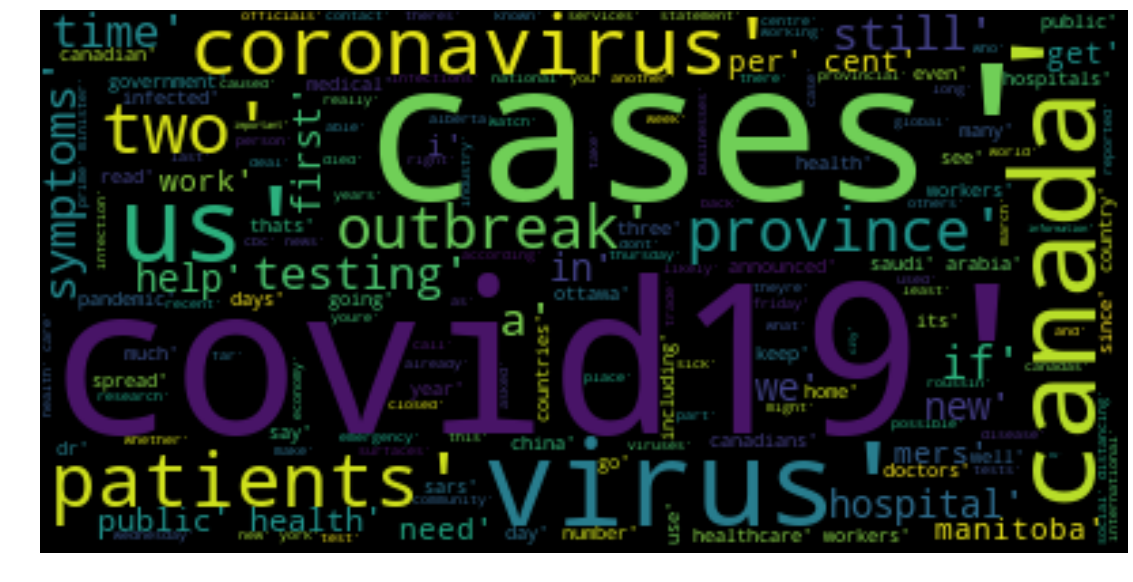

In [179]:
from wordcloud import WordCloud

wordcloud = WordCloud().generate((str(filtered)).lower())
# Display the generated image:
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
   

Coronavirus a 'wake-up call' for Canada's prescription drug supply


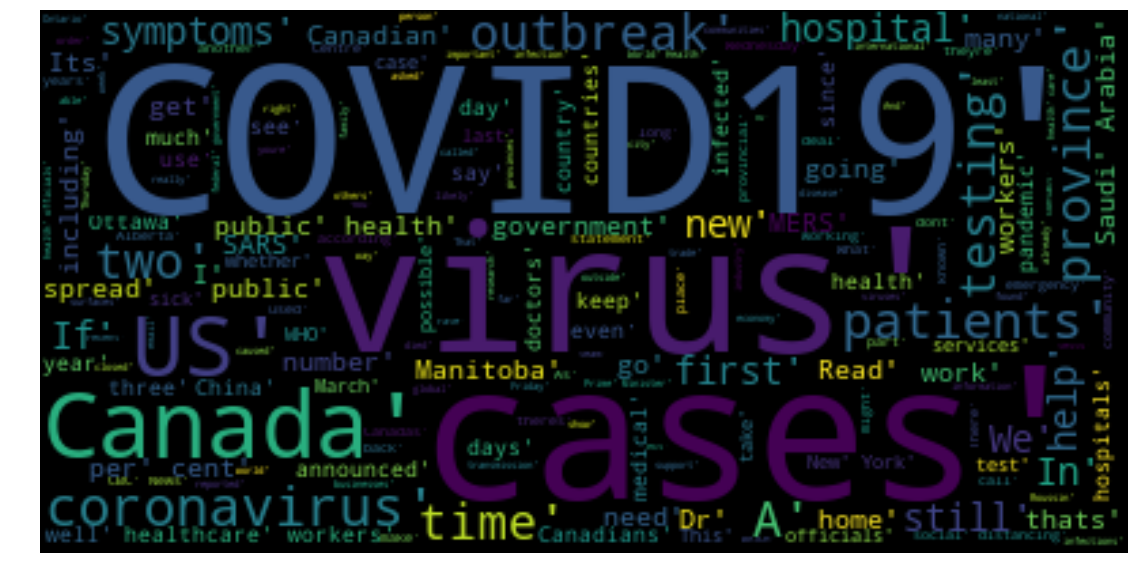

Yukon gov't names 2 possible sources of coronavirus exposure


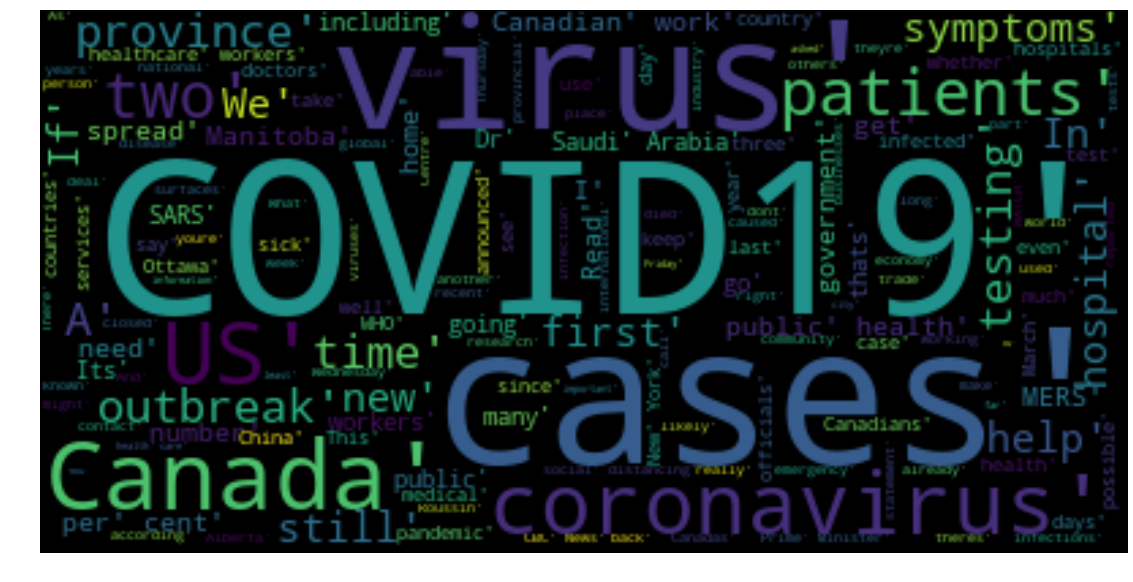

U.S. Senate passes $2T coronavirus relief package


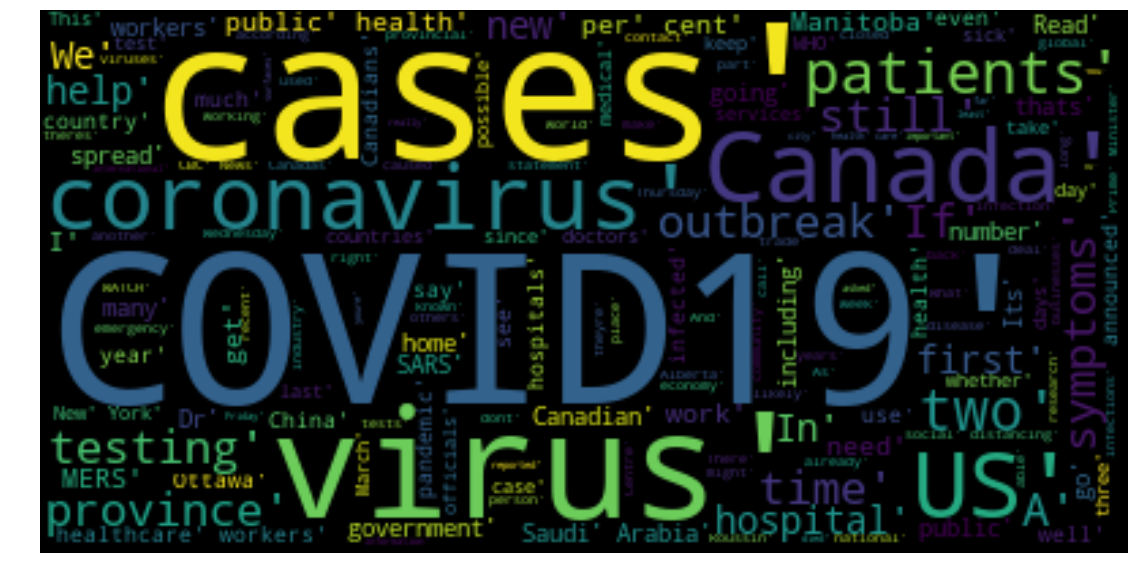

Coronavirus: The latest in drug treatment and vaccine development


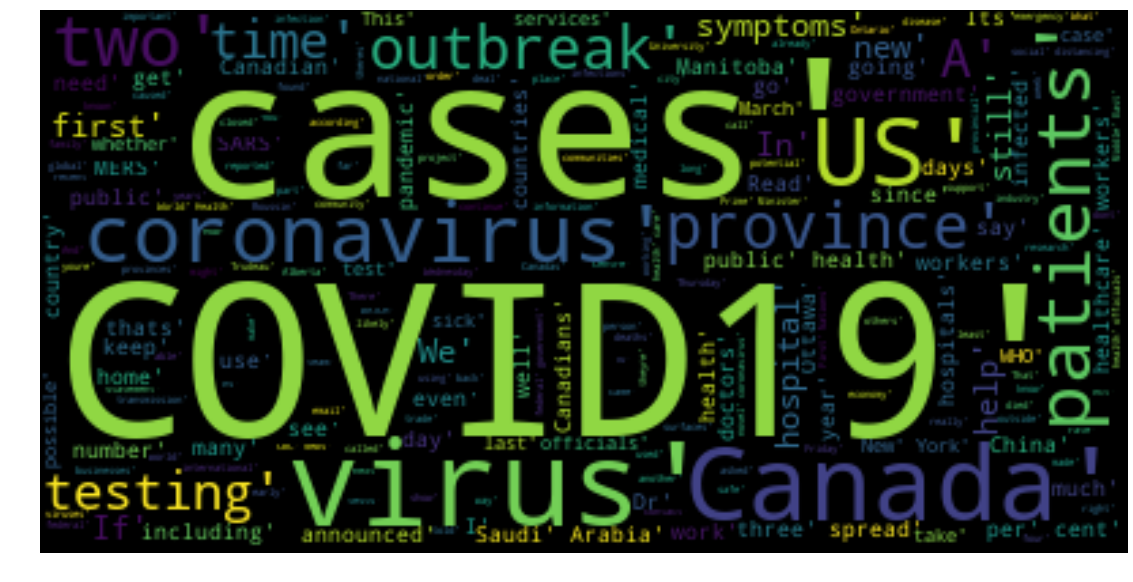

The latest on the coronavirus outbreak for March 26


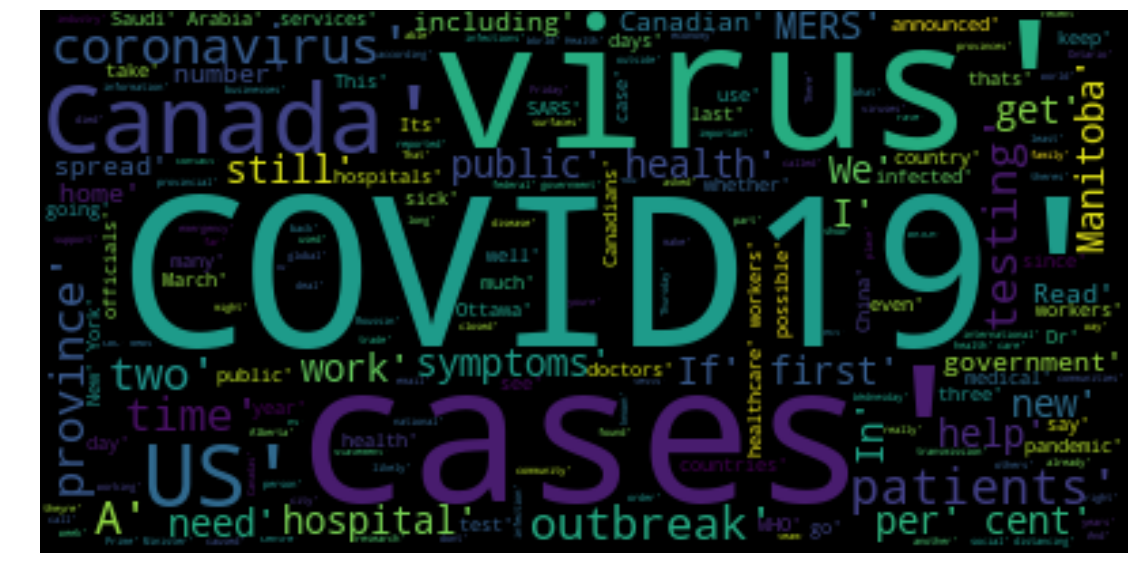

'Worse' pandemic on horizon unless world deals with wildlife markets


KeyboardInterrupt: 

In [180]:
for text in df.title:   
    print(text)
    wordcloud = WordCloud().generate(str(filtered))
# Display the generated image:
    plt.figure( figsize=(20,10) )
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [12]:
#top 10 words in the Jan and before news article till now without text prep

def plot_10_most_common_words(count_data, count_vectorizer):  
    words = count_vectorizer.get_feature_names()  
    total_counts = np.zeros(len(words))  
    for t in count_data:  
        total_counts+=t.toarray()[0] 
        count_dict = (zip(words, total_counts))  
        count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]  
        words = [w[0] for w in count_dict]  
        counts = [w[1] for w in count_dict]  
        x_pos = np.arange(len(words))   
     
    plt.figure(2, figsize=(15, 15/1.6180))  
    plt.subplot(title='10 most common words')  
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})  
    sns.barplot(x_pos, counts, palette='husl')  
    plt.xticks(x_pos, words, rotation=90)   
    plt.xlabel('words')  
    plt.ylabel('counts')  
    plt.show()

In [13]:
count_vectorizer = TfidfVectorizer(stop_words= stop_words)  
count_data = count_vectorizer.fit_transform(df['text'])

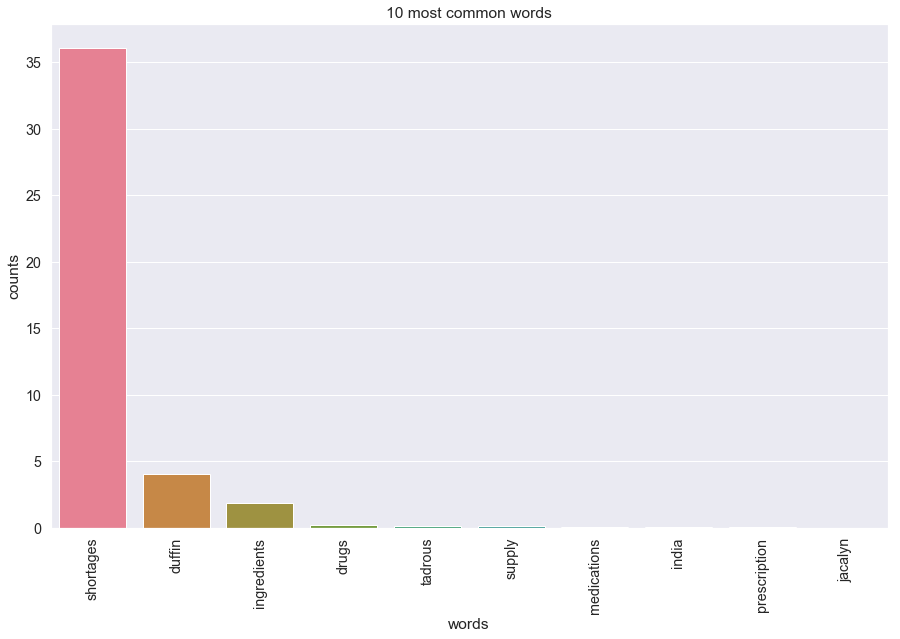

In [14]:
plot_10_most_common_words(count_data, count_vectorizer)

# After text pre-processing , the words seems more relevent shown in the above bar graph 

# The question talks about the reaction of media during the development of COVID- 19, hence for the purpose, data was divided into three sets:

1. Jan and before data*
2. Februray data
3. March data

*As first case of COVID 19 appeared in China during November , so the data after 1st Nov 2019 was considered for the study.

In [184]:
#df.publish_date.value_counts()

In [185]:
#convert object dtype of publish_date to datetime
#pd.to_datetime(df.publish_date)

In [186]:
df_2 = df[df.publish_date > '2019-11-01 00:00:00']

# Categorizing data based on Months (as COVID 19 developed)

In [187]:
#News in January and before
df_Janandbefore_News = df_2[df_2.publish_date < '2020-02-01 00:00:00']

In [188]:
len(df_Janandbefore_News)

185

In [189]:
#News in Feb 
df_Feb_News = df_2[(df_2.publish_date < '2020-03-01 00:00:00') & (df_2.publish_date > '2020-01-01 00:00:00')]

In [190]:
len(df_Feb_News)

582

In [191]:
#News in March
df_March_News = df_2[df_2.publish_date > '2020-02-01 00:00:00']

In [192]:
len(df_March_News)

3350

# Topic Modeling

# January and before News Titles

In [193]:
df_Janandbefore_News.head()

Unnamed: 0  \
510  830          
524  854          
527  859          
551  916          
577  989          

                                                                                                                                            authors  \
510  ['Bridget Yard Is A Video Journalist Based In Saskatoon. She Has Also Worked For Cbc In Fredericton', 'Bathurst', 'Follow Bridget On Twitter']   
524  ['Cbc News']                                                                                                                                     
527  []                                                                                                                                               
551  ['Cbc News']                                                                                                                                     
577  []                                                                                                                                               

                                                            title  \
510  Coronavirus anxiety leaves Sask. with surgical mask shortage   
524  No cases of coronavirus in London: MLHU                        
527  Local retailers feeling impact of coronavirus restrictions     
551  Officials testing Ottawa case for coronavirus                  
577  Clock ticks on containing novel coronavirus                    

            publish_date  \
510  2020-01-31 22:26:00   
524  2020-01-28 21:30:00   
527  2020-01-31 22:16:00   
551  2020-01-29 23:08:00   
577  2020-01-28 19:01:00   

                                                                                                                                                                                                                                                                                   description  \
510  Saskatoon and Regina drugstores are trying to restock surgical masks but suppliers say they're out. Some are fielding up to 30 calls a day requesting masks.                                                                                                                                
524  There are currently no confirmed or suspected cases of the coronavirus in the London and Middlesex County.                                                                                                                                                                                  
527  Retailers in the National Capital Region say they're experiencing some delays in shipments because of restrictions related to the coronavirus.                                                                                                                                              
551  The testing for the first suspected local case of the coronavirus is being conducted in Toronto and the results should be known by Thursday at the latest.                                                                                                                                  
577  There are two key unanswered questions surrounding the novel coronavirus: How easily can it be transmitted between people? And how dangerous is it? The next month in the outbreak could be critical in revealing clues to better answer those questions, infectious disease experts say.   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [194]:
#top 10 words in the Jan and before news article till now without text prep

def plot_10_most_common_words(count_data, count_vectorizer):  
    words = count_vectorizer.get_feature_names()  
    total_counts = np.zeros(len(words))  
    for t in count_data:  
        total_counts+=t.toarray()[0] 
        count_dict = (zip(words, total_counts))  
        count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]  
        words = [w[0] for w in count_dict]  
        counts = [w[1] for w in count_dict]  
        x_pos = np.arange(len(words))   
     
    plt.figure(2, figsize=(15, 15/1.6180))  
    plt.subplot(title='10 most common words')  
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})  
    sns.barplot(x_pos, counts, palette='husl')  
    plt.xticks(x_pos, words, rotation=90)   
    plt.xlabel('words')  
    plt.ylabel('counts')  
    plt.show()

In [195]:
count_vectorizer = CountVectorizer(stop_words= stop_words)  
count_data = count_vectorizer.fit_transform(df_Janandbefore_News['text'])

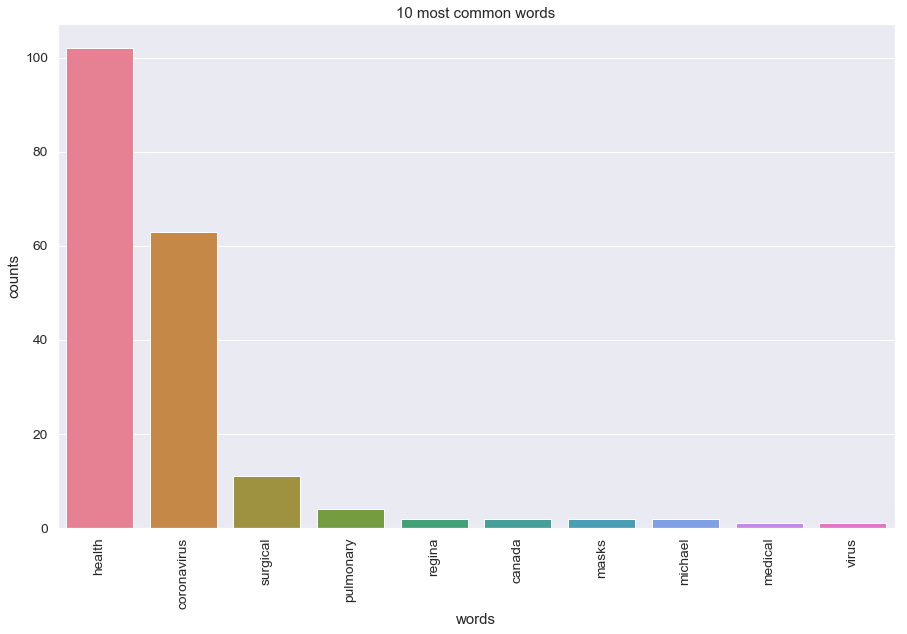

In [196]:
plot_10_most_common_words(count_data, count_vectorizer)

# Topic Modeling using LDA Algorithm

In [197]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [198]:
cv= TfidfVectorizer(max_df=0.95, min_df=2, stop_words=stop_words)

In [199]:
dtm=cv.fit_transform(df_Janandbefore_News['text'])

In [200]:
dtm

<185x4508 sparse matrix of type '<class 'numpy.float64'>'
	with 44815 stored elements in Compressed Sparse Row format>

In [201]:

from sklearn.decomposition import LatentDirichletAllocation

In [202]:
LDA = LatentDirichletAllocation(n_components=7,random_state=42)

In [203]:
LDA.fit(dtm)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=7, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [204]:
len(cv.get_feature_names())

4508

In [205]:
for i in range(10):
    random_word_id = random.randint(0,4398)
    print(cv.get_feature_names()[random_word_id])

criticism
cbc
decicca
southeast
mural
meanwhile
newly
evolved
cleanup
neighbouring


In [206]:
single_topic = LDA.components_[0]

In [207]:
single_topic.argsort()

array([2258,  494, 1942, ..., 2594, 2199,  568], dtype=int64)

In [208]:
top_word_indices = single_topic.argsort()[-10:]

In [209]:
for index in top_word_indices:
    print(cv.get_feature_names()[index])

timep
macmillan
outbreakchinese
huskies
humane
erin
absenteeism
morrison
johnston
branch


In [210]:
for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 20 WORDS FOR TOPIC #{index}')
    print([cv.get_feature_names()[i] for i in topic.argsort()[-20:]])
    print('\n')

THE TOP 20 WORDS FOR TOPIC #0
['assistant', 'heather', 'hospitalizations', 'sarah', 'observing', 'nationally', 'exceeds', 'rcmp', 'absence', 'understands', 'timep', 'macmillan', 'outbreakchinese', 'huskies', 'humane', 'erin', 'absenteeism', 'morrison', 'johnston', 'branch']


THE TOP 20 WORDS FOR TOPIC #1
['okay', 'terry', 'memes', 'bundle', 'territorycoronavirus', 'occupied', 'grade', '2008', 'eerie', 'chat', 'college', 'connection', 'chen', 'algonquin', 'indigenous', 'tourette', 'mural', 'campaign', 'housing', 'collinge']


THE TOP 20 WORDS FOR TOPIC #2
['laya', 'yellowknife', 'rocky', 'lee', 'books', 'jasper', 'hysan', 'molecule', 'predicting', 'dutch', 'relocate', 'mandalay', 'aurora', 'banff', 'tour', 'chwin', 'hotels', 'drosten', 'tours', 'cancellations']


THE TOP 20 WORDS FOR TOPIC #3
['pads', 'inbox', 'brief', 'impeachment', 'sex', 'ambassador', 'defence', 'ye', 'fredericton', 'harry', 'conservative', 'employer', 'climate', 'scotia', 'leadership', 'race', 'schellenberg', 'regi

# Assigning Topic to the dataframe

In [211]:
topic_results =  LDA.transform(dtm)

In [212]:
df_Janandbefore_News['Topic'] = topic_results.argmax(axis=1)

In [213]:
df_Janandbefore_News.head()

Unnamed: 0  \
510  830          
524  854          
527  859          
551  916          
577  989          

                                                                                                                                            authors  \
510  ['Bridget Yard Is A Video Journalist Based In Saskatoon. She Has Also Worked For Cbc In Fredericton', 'Bathurst', 'Follow Bridget On Twitter']   
524  ['Cbc News']                                                                                                                                     
527  []                                                                                                                                               
551  ['Cbc News']                                                                                                                                     
577  []                                                                                                                                               

                                                            title  \
510  Coronavirus anxiety leaves Sask. with surgical mask shortage   
524  No cases of coronavirus in London: MLHU                        
527  Local retailers feeling impact of coronavirus restrictions     
551  Officials testing Ottawa case for coronavirus                  
577  Clock ticks on containing novel coronavirus                    

            publish_date  \
510  2020-01-31 22:26:00   
524  2020-01-28 21:30:00   
527  2020-01-31 22:16:00   
551  2020-01-29 23:08:00   
577  2020-01-28 19:01:00   

                                                                                                                                                                                                                                                                                   description  \
510  Saskatoon and Regina drugstores are trying to restock surgical masks but suppliers say they're out. Some are fielding up to 30 calls a day requesting masks.                                                                                                                                
524  There are currently no confirmed or suspected cases of the coronavirus in the London and Middlesex County.                                                                                                                                                                                  
527  Retailers in the National Capital Region say they're experiencing some delays in shipments because of restrictions related to the coronavirus.                                                                                                                                              
551  The testing for the first suspected local case of the coronavirus is being conducted in Toronto and the results should be known by Thursday at the latest.                                                                                                                                  
577  There are two key unanswered questions surrounding the novel coronavirus: How easily can it be transmitted between people? And how dangerous is it? The next month in the outbreak could be critical in revealing clues to better answer those questions, infectious disease experts say.   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

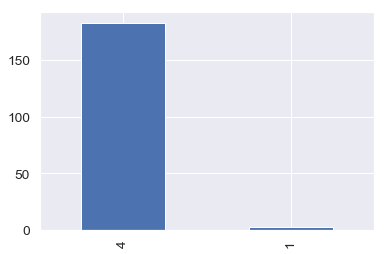

In [214]:
df_Janandbefore_News['Topic'].value_counts().plot('bar')

# Majority of texts belong to topic 4. 

THE TOP 20 WORDS FOR TOPIC #4

['spread', 'city', 'symptoms', 'travel', 'canadians', 'toronto', 'confirmed', 'sars', 'case', 'officials', 'chinese', 'public', 'cases', 'outbreak', 'canada', 'new', 'virus', 'wuhan', 'china', 'health']



In [215]:
text = df_Janandbefore_News.text[(df_Janandbefore_News['Topic']==4)]

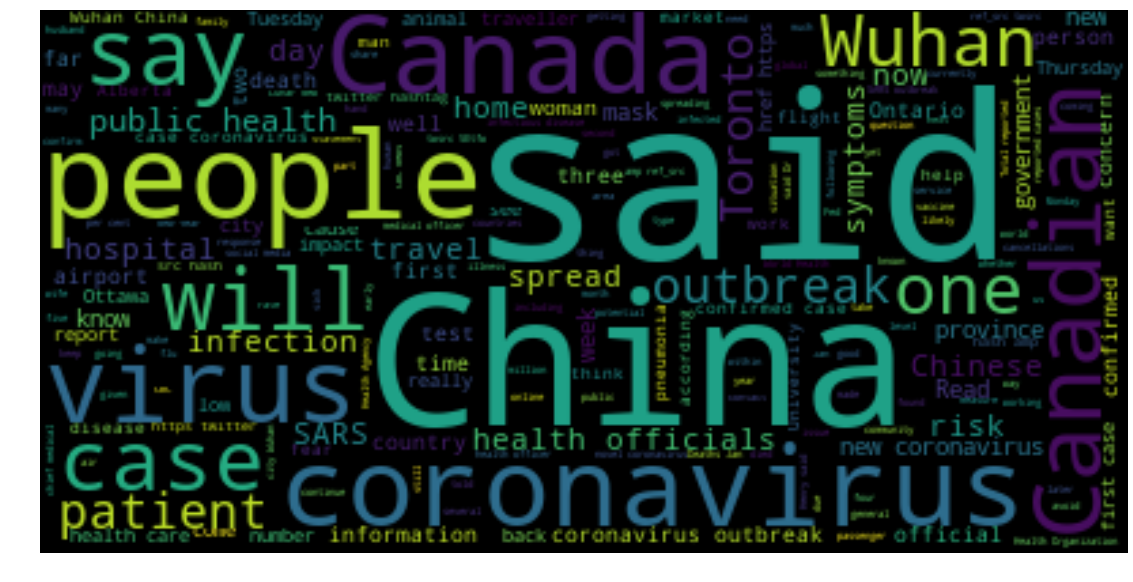

In [216]:

# Visualizing the prominant words

wordcloud = WordCloud().generate(str(text))
# Display the generated image:
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Feburary News titles

In [83]:
df_Feb_News.head()


Unnamed: 0                   authors  \
311  469         ['Cbc News']               
321  483         []                         
330  507         ['The Associated Press']   
343  530         ['The Associated Press']   
355  551         ['Cbc News']               

                                                                                      title  \
311  Sask. updates coronavirus recommendations as spread continues elsewhere                  
321  Ontario confirms 3 new positive cases of coronavirus                                     
330  Amazing Race suspends filming over coronavirus fears                                     
343  Brazil confirms 1st coronavirus case in Latin America                                    
355  What you need to know now about coronavirus: 2nd evacuation plane lands at CFB Trenton   

            publish_date  \
311  2020-02-27 16:00:00   
321  2020-02-29 19:58:00   
330  2020-02-28 22:41:00   
343  2020-02-26 17:15:00   
355  2020-02-10 23:22:00   

                                                                                                                                                                                                                                  description  \
311  As coronavirus continues to spread elsewhere, the government of Saskatchewan has added new recommendations in hopes of preventing an outbreak in the province.                                                                             
321  Ontario has confirmed three new positive cases of coronavirus, bringing the total number of confirmed cases in the province to 11.                                                                                                         
330  CBS said in a statement Friday that it had temporarily suspended production on The Amazing Race and was sending contestants and crew members home as a precautionary measure. Filming on the show's 33rd season was in its early stages.   
343  Brazil's government confirmed on Wednesday that a 61-year-old Brazilian man who travelled to Italy this month has Latin America's first confirmed case of the contagious new coronavirus.                                                  
355  Stay up to date on the coronavirus outbreak and what it means for Canadians.                                                                                                                                                               

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [84]:
count_vectorizer = CountVectorizer(stop_words=stop_words)  
count_data = count_vectorizer.fit_transform(df_Feb_News['text'])

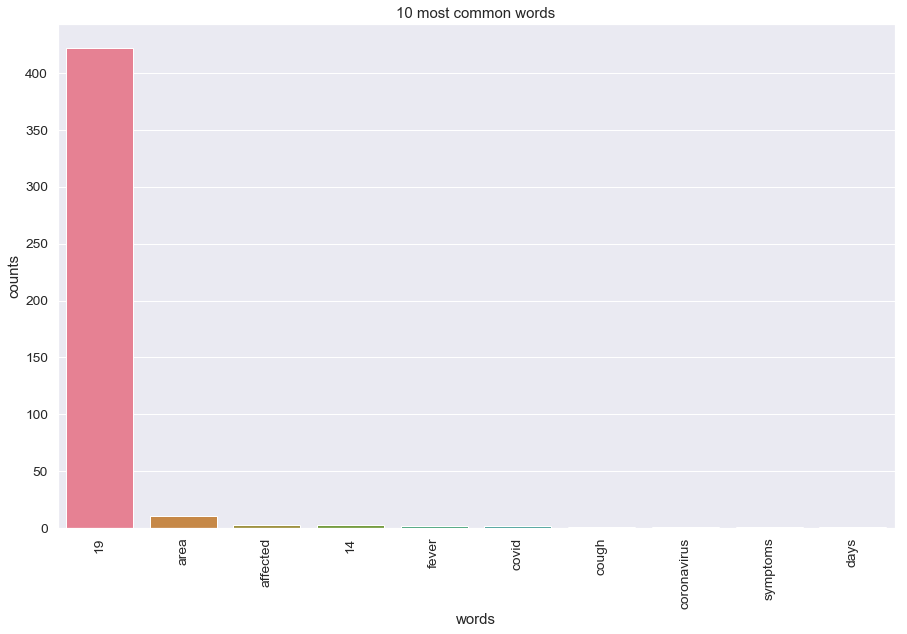

In [85]:
plot_10_most_common_words(count_data, count_vectorizer)

In [86]:
dtm_feb=cv.fit_transform(df_Feb_News['text'])

In [87]:
dtm_feb

<582x9930 sparse matrix of type '<class 'numpy.float64'>'
	with 160396 stored elements in Compressed Sparse Row format>

In [88]:
LDA.fit(dtm_feb)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=7, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [89]:
len(cv.get_feature_names())

9930

In [90]:
for i in range(10):
    random_word_id = random.randint(0,9798)
    print(cv.get_feature_names()[random_word_id])

28
better
rides
currency
agnès
maybe
light
installed
farrah
nct


In [91]:
single_topic_feb = LDA.components_[0]

In [92]:
top_word_indices_feb = single_topic_feb.argsort()[-10:]

In [93]:
for index in top_word_indices_feb:
    print(cv.get_feature_names()[index])

canadians
ship
new
outbreak
wuhan
canada
virus
cases
china
health


In [94]:
for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 20 WORDS FOR TOPIC #{index}')
    print([cv.get_feature_names()[i] for i in topic.argsort()[-20:]])
    print('\n')

THE TOP 20 WORDS FOR TOPIC #0
['19', 'canadian', 'case', 'confirmed', 'quarantine', 'cruise', 'passengers', 'officials', 'chinese', 'public', 'canadians', 'ship', 'new', 'outbreak', 'wuhan', 'canada', 'virus', 'cases', 'china', 'health']


THE TOP 20 WORDS FOR TOPIC #1
['grabher', 'plateymca', 'doorbell', 'asthma', 'fakes', 'capsules', 'ebay', 'counterfeit', 'aliexpress', 'oils', 'asha', 'activated', 'intensifying', 'ted', 'districts', 'employer', 'middlesex', 'sutcliffe', 'mackie', 'fitzgerald']


THE TOP 20 WORDS FOR TOPIC #2
['colossal', 'pboc', 'attracting', 'sha', 'stephanie', 'cp', 'trans', 'weyburn', 'festival', 'herbicide', 'bocconi', 'pitter', 'liquidity', 'jenzer', 'lights', 'saran', 'warren', 'kate', 'howden', 'andrews']


THE TOP 20 WORDS FOR TOPIC #3
['vgh', 'sponsors', 'maryam', 'kenyans', 'abomoslim', 'retroviral', 'enrol', 'admissions', 'cellphones', 'streamline', 'accessible', 'readmission', 'kenyan', 'discharge', 'pilot', 'kenya', 'lejeune', 'weltel', 'kachanoski', 'l

In [95]:
topic_results_feb = LDA.transform(dtm_feb)

In [96]:
topic_results_feb.shape

(582, 7)

In [97]:
df_Feb_News['Topic'] = topic_results_feb.argmax(axis=1)

In [98]:
df_Feb_News.head()

Unnamed: 0                   authors  \
311  469         ['Cbc News']               
321  483         []                         
330  507         ['The Associated Press']   
343  530         ['The Associated Press']   
355  551         ['Cbc News']               

                                                                                      title  \
311  Sask. updates coronavirus recommendations as spread continues elsewhere                  
321  Ontario confirms 3 new positive cases of coronavirus                                     
330  Amazing Race suspends filming over coronavirus fears                                     
343  Brazil confirms 1st coronavirus case in Latin America                                    
355  What you need to know now about coronavirus: 2nd evacuation plane lands at CFB Trenton   

            publish_date  \
311  2020-02-27 16:00:00   
321  2020-02-29 19:58:00   
330  2020-02-28 22:41:00   
343  2020-02-26 17:15:00   
355  2020-02-10 23:22:00   

                                                                                                                                                                                                                                  description  \
311  As coronavirus continues to spread elsewhere, the government of Saskatchewan has added new recommendations in hopes of preventing an outbreak in the province.                                                                             
321  Ontario has confirmed three new positive cases of coronavirus, bringing the total number of confirmed cases in the province to 11.                                                                                                         
330  CBS said in a statement Friday that it had temporarily suspended production on The Amazing Race and was sending contestants and crew members home as a precautionary measure. Filming on the show's 33rd season was in its early stages.   
343  Brazil's government confirmed on Wednesday that a 61-year-old Brazilian man who travelled to Italy this month has Latin America's first confirmed case of the contagious new coronavirus.                                                  
355  Stay up to date on the coronavirus outbreak and what it means for Canadians.                                                                                                                                                               

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

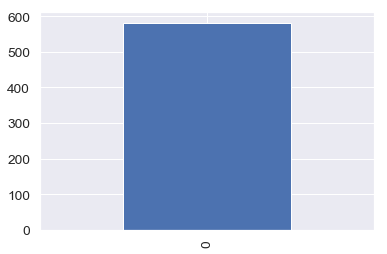

In [99]:
df_Feb_News['Topic'].value_counts().plot('bar')

# The text from Februray articles belongs to topic# 0 

THE TOP 20 WORDS FOR TOPIC #0

['19', 'canadian', 'case', 'confirmed', 'quarantine', 'cruise', 'passengers', 'officials', 'chinese', 'public', 'canadians', 'ship', 'new', 'outbreak', 'wuhan', 'canada', 'virus', 'cases', 'china', 'health']

In [155]:
text_2 = df_Feb_News.text[(df_Feb_News.Topic==0)]

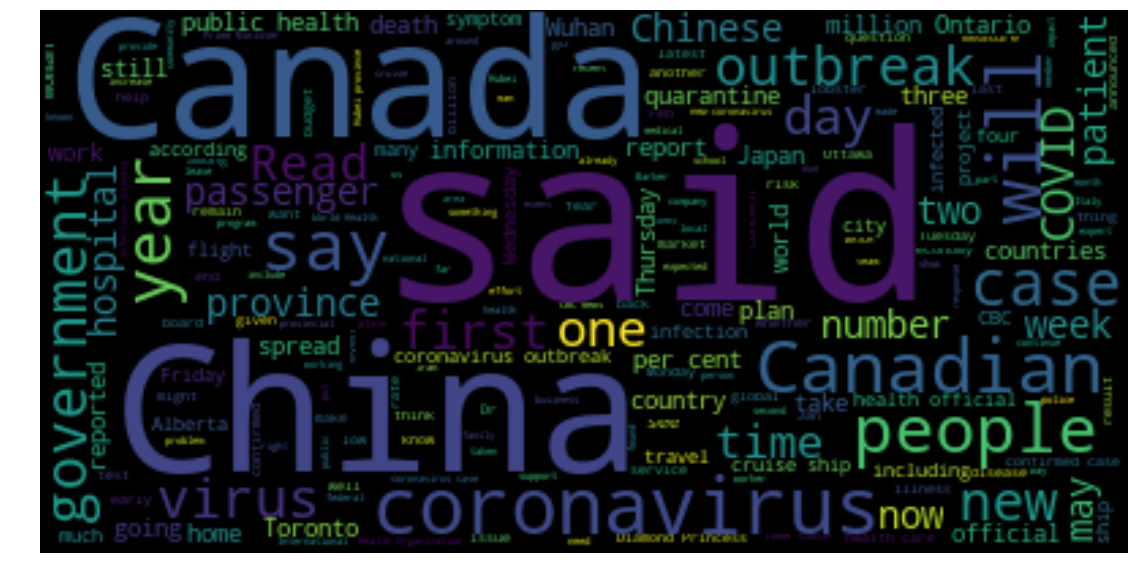

In [157]:
# Visualizing the prominant words

wordcloud = WordCloud().generate(str(text_2))
# Display the generated image:
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# March News Titles

In [100]:
df_March_News.head(3)


Unnamed: 0                   authors  \
0  0           ['Cbc News']               
1  1           ['Cbc News']               
2  2           ['The Associated Press']   

                                                                title  \
0  Coronavirus a 'wake-up call' for Canada's prescription drug supply   
1  Yukon gov't names 2 possible sources of coronavirus exposure         
2  U.S. Senate passes $2T coronavirus relief package                    

          publish_date  \
0  2020-03-27 08:00:00   
1  2020-03-27 01:45:00   
2  2020-03-26 05:13:00   

                                                                                                                                                                                                                                                description  \
0  Canadian pharmacies are limiting how much medication can be dispensed to try to prevent shortages, recognizing that most active ingredients for drugs come from India and China and medical supply chains have been disrupted by the spread of COVID-19.   
1  The Yukon government has identified two places in Whitehorse — a church and a dental clinic — where people may have been exposed to the coronavirus in recent weeks.                                                                                       
2  The Senate has passed an unparalleled $2.2 trillion economic rescue package steering aid to businesses, workers and health care systems engulfed by the coronavirus pandemic                                                                               

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [101]:
count_vectorizer = CountVectorizer(stop_words=stop_words)  
count_data = count_vectorizer.fit_transform(df_March_News['text'])

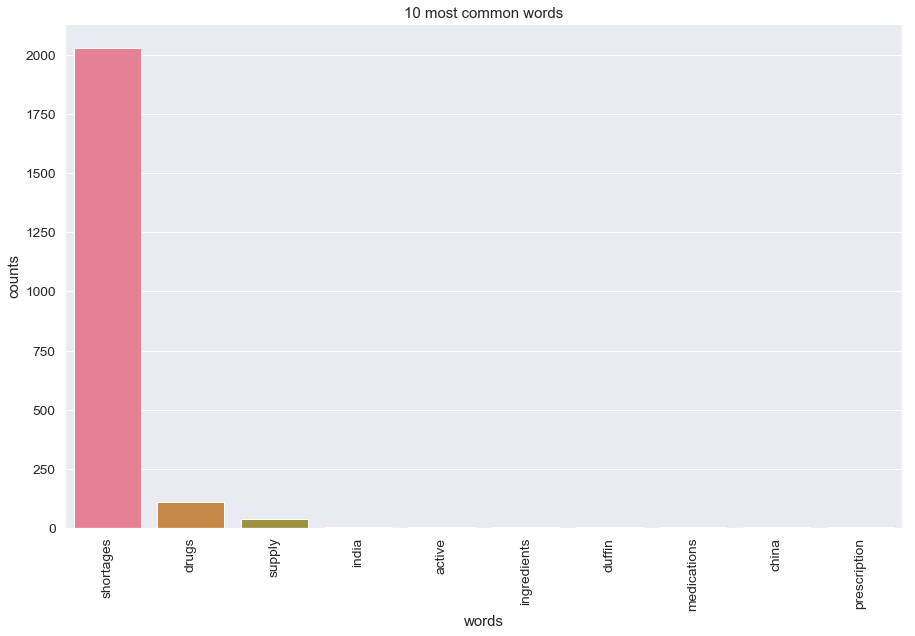

In [102]:
plot_10_most_common_words(count_data, count_vectorizer)

# LDA

In [103]:
LDA_mar = LatentDirichletAllocation(n_components=12,random_state=42)

In [104]:
dtm_March=cv.fit_transform(df_March_News.text)

In [105]:
dtm_March

<3350x23533 sparse matrix of type '<class 'numpy.float64'>'
	with 859611 stored elements in Compressed Sparse Row format>

In [106]:
LDA_mar.fit(dtm_March)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=12, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [107]:
len(cv.get_feature_names())

23533

In [108]:
for i in range(10):
    random_word_id = random.randint(0,23537)
    print(cv.get_feature_names()[random_word_id])

ahmar
checker
alters
koch
automakers
travelgoc
hatch
rushed
implementing
cancellationsthe


In [109]:
single_topic_March = LDA_mar.components_[0]

In [110]:
top_word_indices_March = single_topic_March.argsort()[-10:]

In [111]:
for index in top_word_indices_March:
    print(cv.get_feature_names()[index])

care
government
province
public
canada
coronavirus
cases
19
covid
health


In [112]:
for index,topic in enumerate(LDA_mar.components_):
    print(f'THE TOP 20 WORDS FOR TOPIC #{index}')
    print([cv.get_feature_names()[i] for i in topic.argsort()[-20:]])
    print('\n')

THE TOP 20 WORDS FOR TOPIC #0
['march', 'symptoms', 'self', 'confirmed', 'cbc', 'china', 'city', 'virus', 'new', 'home', 'care', 'government', 'province', 'public', 'canada', 'coronavirus', 'cases', '19', 'covid', 'health']


THE TOP 20 WORDS FOR TOPIC #1
['rombotis', 'maclachlan', 'mohammed', 'iga', 'karahalios', 'meechum', 'cameco', 'salmond', 'unifor', 'proofpoint', 'braonáin', 'mine', 'scottish', 'berries', 'yu', 'puffers', 'refinery', 'fcl', 'buffett', 'diavik']


THE TOP 20 WORDS FOR TOPIC #2
['hydroxychloroquine', 'lng', 'kilfoy', 'ezra', 'guatemala', 'bears', 'cyber', 'larkin', 'eviction', 'disinformation', 'awards', 'mahdavi', 'cse', 'juno', 'grace', 'cudmore', 'junos', 'lauderdale', 'meili', 'arruda']


THE TOP 20 WORDS FOR TOPIC #3
['crc', 'mccoy', 'allies', 'barnes', 'brainard', 'carr', 'coon', 'broughton', 'godfrey', 'morrow', 'attawapiskat', 'yu', 'ciavaglia', 'offshore', 'warr', 'refinery', 'shell', 'barrels', 'sparling', 'girard']


THE TOP 20 WORDS FOR TOPIC #4
['manco

# Attaching Topics labels to Original Articles

In [113]:
dtm_March

<3350x23533 sparse matrix of type '<class 'numpy.float64'>'
	with 859611 stored elements in Compressed Sparse Row format>

In [114]:
dtm.shape

(185, 4508)

In [115]:
len(df_March_News)

3350

In [116]:
topic_results = LDA_mar.transform(dtm_March)

In [117]:
topic_results.shape

(3350, 12)

In [118]:
topic_results[0]

array([0.82258408, 0.09982063, 0.00775895, 0.00775994, 0.00775963,
       0.00775896, 0.00776098, 0.00775894, 0.00776152, 0.00775878,
       0.00775878, 0.0077588 ])

In [119]:
topic_results[0].round(2)

array([0.82, 0.1 , 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01])

In [120]:
topic_results[0].argmax()

0

In [121]:
df_March_News['Topic']= topic_results.argmax(axis=1)

In [122]:
df_March_News.head()

Unnamed: 0                   authors  \
0  0           ['Cbc News']               
1  1           ['Cbc News']               
2  2           ['The Associated Press']   
3  3           ['Cbc News']               
4  4           ['Cbc News']               

                                                                title  \
0  Coronavirus a 'wake-up call' for Canada's prescription drug supply   
1  Yukon gov't names 2 possible sources of coronavirus exposure         
2  U.S. Senate passes $2T coronavirus relief package                    
3  Coronavirus: The latest in drug treatment and vaccine development    
4  The latest on the coronavirus outbreak for March 26                  

          publish_date  \
0  2020-03-27 08:00:00   
1  2020-03-27 01:45:00   
2  2020-03-26 05:13:00   
3  2020-03-27 00:36:00   
4  2020-03-26 20:57:00   

                                                                                                                                                                                                                                                description  \
0  Canadian pharmacies are limiting how much medication can be dispensed to try to prevent shortages, recognizing that most active ingredients for drugs come from India and China and medical supply chains have been disrupted by the spread of COVID-19.   
1  The Yukon government has identified two places in Whitehorse — a church and a dental clinic — where people may have been exposed to the coronavirus in recent weeks.                                                                                       
2  The Senate has passed an unparalleled $2.2 trillion economic rescue package steering aid to businesses, workers and health care systems engulfed by the coronavirus pandemic                                                                               
3  Scientists around the world are racing to find novel ways to treat, mitigate or prevent infection from the novel coronavirus. Here are the latest developments.                                                                                            
4  The latest on the coronavirus outbreak from CBC News for Thursday, March 26                                                                                                                                                                                

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [123]:
df_March_News['Topic'].value_counts()

0    3346
4    4   
Name: Topic, dtype: int64

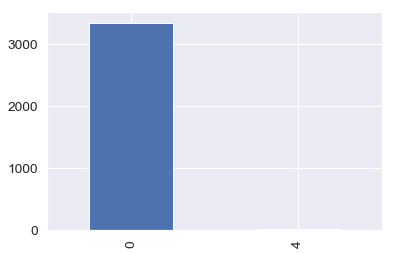

In [124]:
df_March_News['Topic'].value_counts().plot('bar')



# All the March articles are related to topic# 0




THE TOP 20 WORDS FOR TOPIC #0

['march', 'symptoms', 'self', 'confirmed', 'cbc', 'china', 'city', 'virus', 'new', 'home', 'care', 'government', 'province', 'public', 'canada', 'coronavirus', 'cases', '19', 'covid', 'health']


In [159]:
text_3 = df_March_News.text[(df_March_News.Topic==0)]

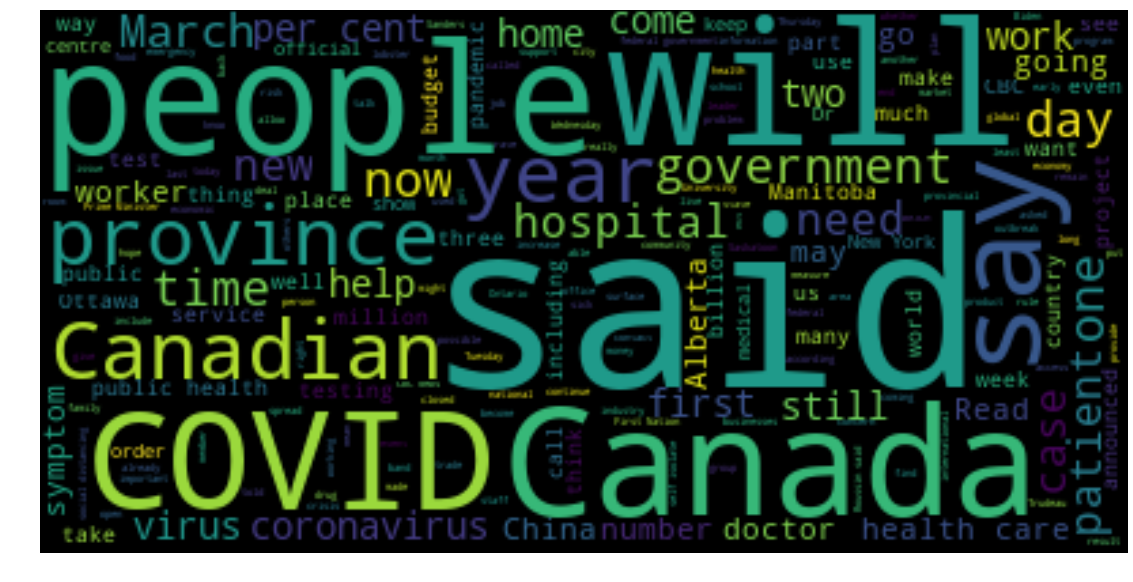

In [160]:
wordcloud = WordCloud().generate(str(text_3))
# Display the generated image:
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Answer:

 # We can see from above, that as the time progressed News artilces started talking more about COVID 19 issues, Starting from November till January and February the reaction can be called as under-reaction, articles were not much on COVID 19 but during March, the time when COVID 19 issue became a serious threat the News articles started reacting, which can not be said as over-reacton; considering the currect situation of COVID 19
  

# NOTE:


The above model can be tweeked in order to get better results.These are few steps which could be added to get better output:

1) NMF algorithm can be used instead of LDA algorithm for topic modeling - I have attached the analysis using NMF algorithm on github while tweeking a little in text pre-processing

2) More words which are not very useful, as per domain knowledge, can be added in Stop_word list. - 

3) Hyperparameter tuning can be done to increase the consistency of each topic.

# Providing an introduction for text classification (not related to this project)

# Text Classification

In [448]:
cv= TfidfVectorizer(max_df=0.95, min_df=2, stop_words=stop_words)

In [449]:
dtm_all = cv.fit_transform(df_2['text'])

In [450]:
true_k = 2
model = KMeans(n_clusters= true_k, init = 'k-means++', max_iter = 100, n_init = 1)
model.fit(dtm_all)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=2, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [451]:
order_centroid = model.cluster_centers_.argsort()[:,::-1]
terms = cv.get_feature_names()

In [452]:
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroid[i, :10]:
        print(' %s' % terms[ind])

Cluster 0:
 covid
 19
 people
 health
 coronavirus
 canada
 government
 home
 city
 cbc
Cluster 1:
 health
 cases
 19
 covid
 people
 coronavirus
 china
 confirmed
 public
 care


# NOTE:

Tried text classification to classify the texts but it is not classifying well , hence I will try with other classification models.

# Reference

1.https://stackoverflow.com/questions/42068474/tfidfvectorizer-how-does-the-vectorizer-with-fixed-vocab-deal-with-new-words/42069027

2. https://towardsdatascience.com/testing-the-waters-with-nltk-3600574f891c

3. https://towardsdatascience.com/basic-binary-sentiment-analysis-using-nltk-c94ba17ae386

4. https://towardsdatascience.com/sentiment-analysis-with-text-mining-13dd2b33de27
    
5. https://medium.com/@datamonsters/text-preprocessing-in-python-steps-tools-and-examples-bf025f872908